<a href="https://colab.research.google.com/github/subh-775/Academicia/blob/main/Augmentation_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets==2.12.0
!pip install huggingface-hub==0.14.1
!pip install pillow==9.5.0
!pip install torchvision==0.15.1

In [ ]:
!pip install datasets

In [ ]:
import os
from datasets import DatasetDict
from PIL import Image
import torch
import random
from huggingface_hub import login
login()

In [ ]:
# !pip install pillow==9.5.0 --upgrade
# !pip install --upgrade pillow

In [6]:
import torchvision.transforms as T

In [10]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
dataset = load_dataset("Subh775/Rice-Disease-Classification-Dataset")

In [11]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4078
    })
})


<ipython-input-4-5fb8b7e23b10>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts_named.keys()), y=list(label_counts_named.values()), palette="viridis")


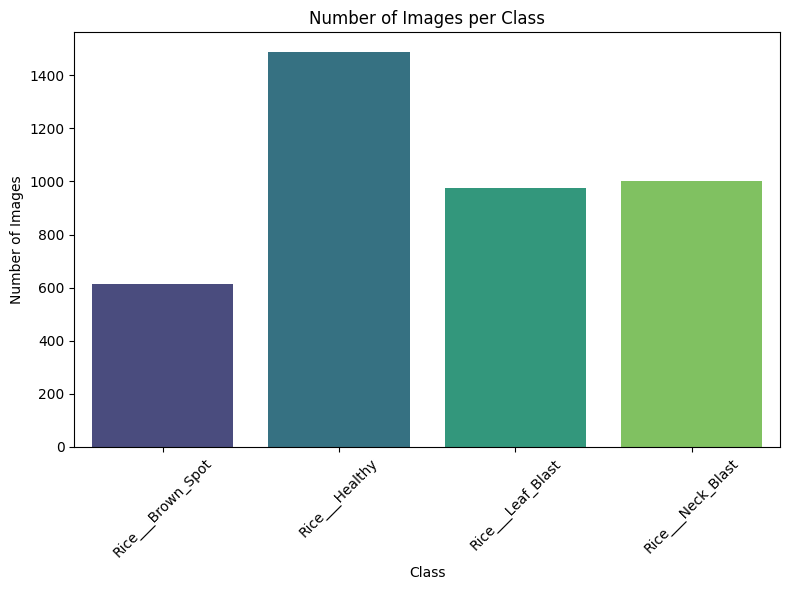

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
dataset = load_dataset("Subh775/Rice-Disease-Classification-Dataset", split="train")

# Extract labels
labels = [example['label'] for example in dataset]

# Count occurrences of each label
from collections import Counter
label_counts = Counter(labels)

# Map label indices to class names
label_names = dataset.features['label'].names
label_counts_named = {label_names[k]: v for k, v in label_counts.items()}

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(label_counts_named.keys()), y=list(label_counts_named.values()), palette="viridis")
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
#data augmentation
augment_transform = T.Compose([
    T.RandomResizedCrop(size=256, scale=(0.8, 1.0)),  # Crop portion of image
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomRotation(degrees=15),
    T.ToTensor()
])

In [15]:
# 1. Create an output folder
base_dir = "augmented_dataset"
os.makedirs(base_dir, exist_ok=True)

# 2. Get label names for easy mapping
label_names = dataset['train'].features["label"].names  # e.g. ["Rice__Brown_Spot", "Rice__Healthy", ...]

# 3. Group by class
grouped_data = {}
for sample in dataset['train']:
    img = sample["image"]
    label_id = sample["label"]
    label_name = label_names[label_id]

    if label_name not in grouped_data:
        grouped_data[label_name] = []
    grouped_data[label_name].append(img)

# 4. For each class, augment to reach 1,000 images
desired_count = 1000

for label_name, images in grouped_data.items():
    class_dir = os.path.join(base_dir, label_name)
    os.makedirs(class_dir, exist_ok=True)

    print(f"Processing class: {label_name} | Original count: {len(images)}")

    # Save the original images first
    for idx, pil_img in enumerate(images):
        # Convert to RGB just in case
        pil_img = pil_img.convert("RGB")
        pil_img.save(os.path.join(class_dir, f"{label_name}_{idx:04d}.jpg"))

    # If we have fewer than desired_count, augment
    current_count = len(images)
    if current_count < desired_count:
        needed = desired_count - current_count
        print(f"  -> Augmenting {needed} new images...")

        for extra_idx in range(needed):
            # Pick a random image from the original set
            pil_img = random.choice(images).convert("RGB")

            # Apply random transformations
            aug_img_tensor = augment_transform(pil_img)

            # Convert the tensor back to PIL before saving
            aug_img = T.ToPILImage()(aug_img_tensor)

            # Save the augmented image
            save_path = os.path.join(class_dir, f"{label_name}_aug_{extra_idx:04d}.jpg")
            aug_img.save(save_path)
    else:
        print("  -> Already has 1000 or more images; skipping augmentation.")

print("✅ Augmentation complete!")

Processing class: Rice___Brown_Spot | Original count: 613
  -> Augmenting 387 new images...
Processing class: Rice___Healthy | Original count: 1488
  -> Already has 1000 or more images; skipping augmentation.
Processing class: Rice___Leaf_Blast | Original count: 977
  -> Augmenting 23 new images...
Processing class: Rice___Neck_Blast | Original count: 1000
  -> Already has 1000 or more images; skipping augmentation.
✅ Augmentation complete!


In [16]:
# Now, create a new dataset from this folder
aug_ds = load_dataset("imagefolder", data_dir=base_dir)
print(aug_ds)

Resolving data files:   0%|          | 0/4488 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4488
    })
})


In [17]:
# Convert to DatasetDict if needed
aug_ds = DatasetDict({"train": aug_ds["train"]})

# You can push to your own user namespace (replace "YourUserName/..." as needed)
aug_ds.push_to_hub("Subh775/Rice-Disease-Augmented")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/4488 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/45 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Subh775/Rice-Disease-Augmented/commit/bff114a444cd7a253c5a6a8c36f6f928fb5e447b', commit_message='Upload dataset', commit_description='', oid='bff114a444cd7a253c5a6a8c36f6f928fb5e447b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Subh775/Rice-Disease-Augmented', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Subh775/Rice-Disease-Augmented'), pr_revision=None, pr_num=None)